## Autoencoder con Keras para visualizar los textos de inciso a) en 2D y 3D. Resultados comparados con Isomap, T-SNE y PCA.

### Funciones para graficar

In [ ]:
# Para machine learning
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Para deep learning
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Para procesamiento de texto
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import os
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def plot_2d_results(encoded_data, title="Autoencoder 2D"):
    #Grafica resultados en 2D
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(encoded_data[:, 0], encoded_data[:, 1], alpha=0.55)
    plt.title(title)
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_3d_results(encoded_data, title="Autoencoder 3D"):
    #Grafica resultados en 3D
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], alpha=0.55)
    ax.set_title(title)
    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')
    ax.set_zlabel('Dimensión 3')
    plt.show()

def compare_methods(methods_2d, methods_3d):
    #Compara diferentes métodos de reducción de dimensionalidad
    fig, axes = plt.subplots(2, 2, figsize=(10,8))
    axes = axes.ravel()

    for i, (name, data) in enumerate(methods_2d.items()):
        axes[i].scatter(data[:, 0], data[:, 1], alpha=0.55)
        axes[i].set_title(f'{name} - 2D')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Gráficos 3D
    fig = plt.figure(figsize=(10,8))

    for i, (name, data) in enumerate(methods_3d.items(), 1):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.7)
        ax.set_title(f'{name} - 3D')

    plt.tight_layout()
    plt.show()

### Autoencoder con Keras

In [ ]:
def create_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_layer = keras.Input(shape=(input_dim,))
    encoded = layers.Dense(144, activation='sigmoid')(input_layer)
    encoded = layers.Dense(36, activation='gelu')(encoded)
    encoded = layers.Dense(12, activation='gelu')(encoded)
    encoded = layers.Dense(encoding_dim, activation='gelu', name='encoded')(encoded)

    # Decoder
    decoded = layers.Dense(12, activation='gelu')(encoded)
    encoded = layers.Dense(36, activation='gelu')(encoded)
    decoded = layers.Dense(144, activation='gelu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    # Modelos
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    return autoencoder, encoder

def train_autoencoder(autoencoder, X_train, epochs=100, batch_size=64):

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    history = autoencoder.fit(X_train, X_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_split=0.20,
                            verbose=1)
    return history

## a) Textos Oz_books

### Procesamiento de los textos: 'oz_books'

In [ ]:
def procesar_libros_oz():
    todos_los_capitulos = []
    ruta_carpeta = '/content/drive/MyDrive/Colab Notebooks/oz_books'

    # Verificar si la carpeta existe
    if not os.path.exists(ruta_carpeta):
        print(f"Error: La carpeta '{ruta_carpeta}' no existe.")
        return todos_los_capitulos

    # Obtener la lista de archivos en la carpeta
    archivos = [f for f in os.listdir(ruta_carpeta) if os.path.isfile(os.path.join(ruta_carpeta, f))]

    # Proceso de cada archivo
    for archivo in archivos:
        ruta_archivo = os.path.join(ruta_carpeta, archivo)

        # Intentar diferentes codificaciones para leer el archivo
        codificaciones = ['utf-8', 'latin-1', 'cp1252']
        contenido = None

        for codificacion in codificaciones:
            try:
                with open(ruta_archivo, 'r', encoding=codificacion) as f:
                    contenido = f.read()
                break  # Si se pudo leer correctamente, salir del bucle
            except UnicodeDecodeError:
                continue

        if contenido is None:
            print(f"No se pudo decodificar el archivo '{archivo}'.")
            continue

        # Buscar la palabra clave QUE AÑADÍ MANUALMENTE A CADA ARCHIVO
        palabra_clave = "_..---+KEY+---.._"
        indice_clave = contenido.find(palabra_clave)

        if indice_clave != -1:
            # Extraer el texto a partir de la palabra clave
            texto_despues_clave = contenido[indice_clave + len(palabra_clave):]

            # Encontrar todos los inicios de capítulos
            patron_capitulo = r'(?:Chapter|CHAPTER)\s'
            posiciones_capitulos = [(m.start(), m.group()) for m in re.finditer(patron_capitulo, texto_despues_clave)]

            if not posiciones_capitulos:
                print(f"No se encontraron capítulos en el archivo '{archivo}'.")
                continue

            # Extraer el texto de cada capítulo
            for i in range(len(posiciones_capitulos)):
                inicio = posiciones_capitulos[i][0]
                fin = posiciones_capitulos[i+1][0] if i+1 < len(posiciones_capitulos) else len(texto_despues_clave)
                texto_capitulo = texto_despues_clave[inicio:fin].strip()
                todos_los_capitulos.append(texto_capitulo)

    return todos_los_capitulos


In [ ]:
capitulos = procesar_libros_oz()
print(f"\nTotal de capítulos encontrados: {len(capitulos)}")


Total de capítulos encontrados: 599


In [ ]:
stop_words = {'i', 'me', 'my', 'we', 'our', 'you', 'he', 'him', 'she', 'her', 'it', 'its', 'they', 'them',
              'what', 'which', 'who', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were',
              'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'a', 'an', 'the', 'and', 'but',
              'if', 'or', 'as', 'of', 'at', 'by', 'for', 'with', 'to', 'from', 'in', 'out', 'on', 'off', 'CHAPTER', 'Chapter', 'chapter'}

def preprocess(text):
   # Filtrar palabras muy cortas y tokenizar
    text = text.lower()
    text = re.sub(r'[\d]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()

    tokens = [word for word in tokens if len(word) >= 2]
    return ' '.join(tokens)

# semi-Preprocesamiento de los textos
processed_chapters = []
for chapter in capitulos:
    # Preprocesar el texto
    processed_text = preprocess(chapter)
    words = processed_text.split()
    filtered_words = [word for word in words if word not in stop_words]
    processed_chapters.append(' '.join(filtered_words))

In [ ]:
def preprocess_texts(texts, top_n_words=100):
    #Ahora procesa cada CAPITULO, extrayendo las palabras más frecuentes
    stop_words = set(stopwords.words('english'))
    all_words = []
    cleaned_texts = []

    for text in texts:
        # Convertir a minúsculas y eliminar puntuación
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)

        # Tokenizar
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        cleaned_texts.append(filtered_tokens)
        all_words.extend(filtered_tokens)

    # n palabras más frecuentes
    word_freq = Counter(all_words)
    top_words = [word for word, freq in word_freq.most_common(top_n_words)]

    return cleaned_texts, top_words

def texts_to_vectors(cleaned_texts, top_words):
    # Pasa de textos a vectores binarios (One-Hot)
    word_to_idx = {word: idx for idx, word in enumerate(top_words)}
    vectors = []

    for tokens in cleaned_texts:
        vector = np.zeros(len(top_words))
        for token in tokens:
            if token in word_to_idx:
                vector[word_to_idx[token]] = 1
        vectors.append(vector)

    return np.array(vectors)

In [ ]:
sizew=[]
for i in processed_chapters:
    sizew.append(len(i.split()))
min_palabras = min(sizew)

# Pre-procesado de los textos
print("Procesando textos...")
cleaned_texts, top_words = preprocess_texts(processed_chapters, top_n_words=min_palabras)
print(f"Palabras más frecuentes encontradas: {len(top_words)}")
print(len(cleaned_texts),len(top_words))

# Vectorizar texto
X_data = texts_to_vectors(cleaned_texts, top_words)

print(f"Capitulo Vectorizado: {X_data.shape}", X_data[1])


Procesando textos...
Palabras más frecuentes encontradas: 208
599 208
Capitulo Vectorizado: (599, 208) [1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.]


### Entrenamiento del Modelo (Autoencoder)

In [ ]:
# Autoencoders
print("\nEntrenando Autoencoder 2D...")
keras.utils.set_random_seed(60)
autoencoder_2d, encoder_2d = create_autoencoder(input_dim=min_palabras, encoding_dim=2)
history_2d = train_autoencoder(autoencoder_2d, X_data, epochs=120)

print("\nEntrenando Autoencoder 3D...")
autoencoder_3d, encoder_3d = create_autoencoder(input_dim=min_palabras, encoding_dim=3)
history_3d = train_autoencoder(autoencoder_3d, X_data, epochs=120)


Entrenando Autoencoder 2D...

Entrenando Autoencoder 3D...


### Comparación entre los diferentes modelos (Isomap, T-SNE y PCA.)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint

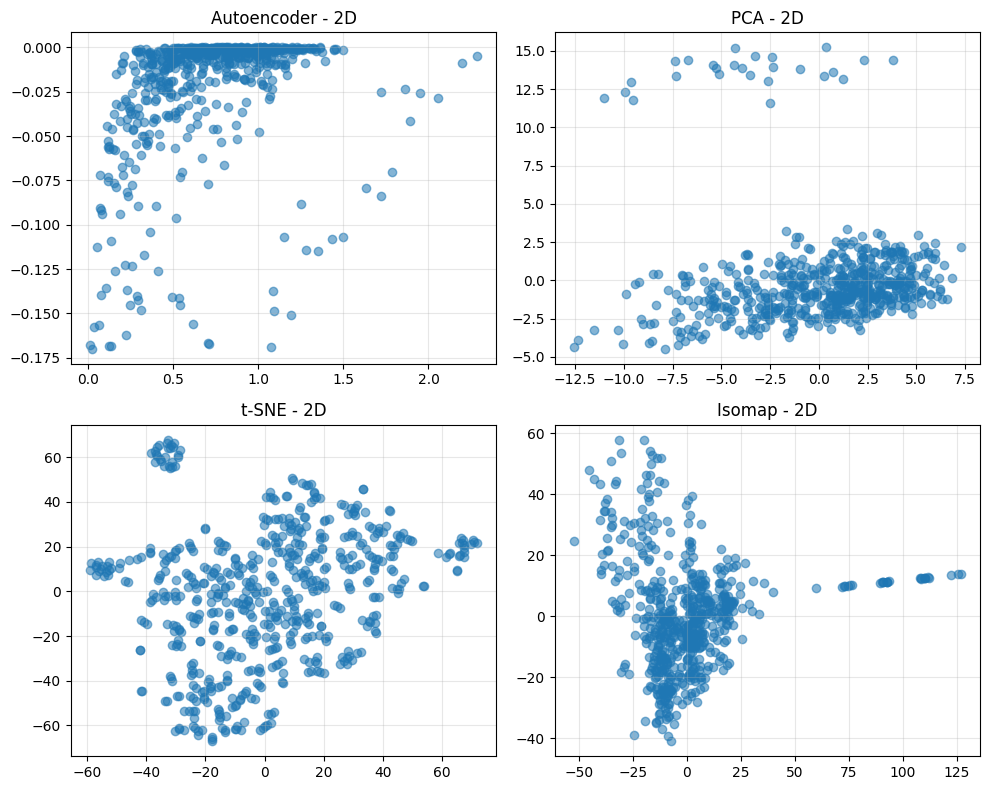

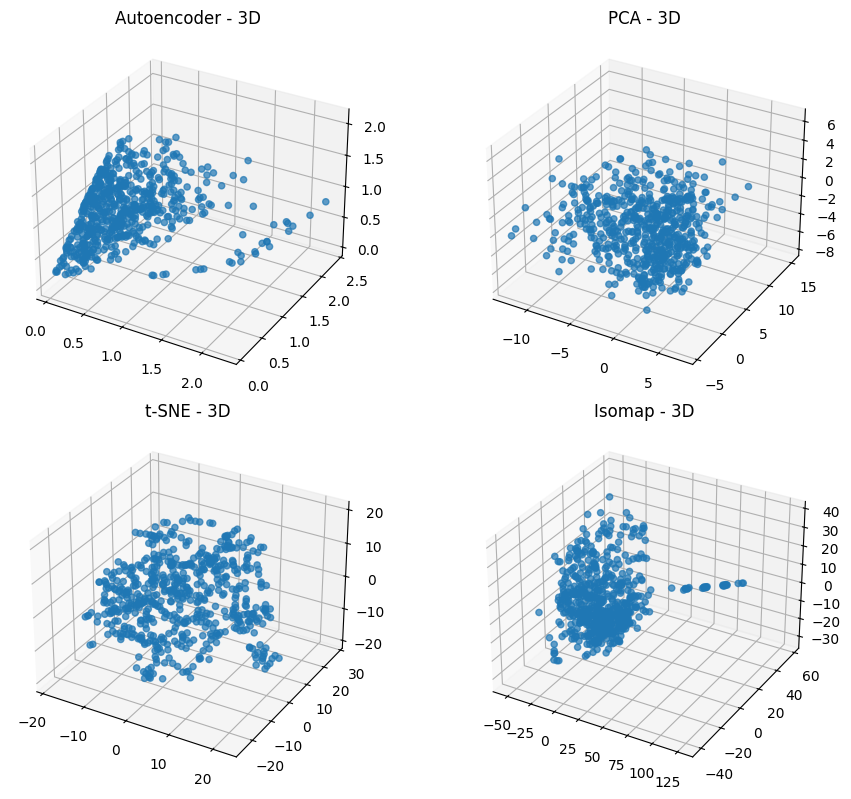

In [ ]:
# Normalizar datos para métodos tradicionales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

## AutoEncoder
encoded_2d = encoder_2d.predict(X_data)
encoded_3d = encoder_3d.predict(X_data)

# PCA
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)
pca_result_2d = pca_2d.fit_transform(X_scaled)
pca_result_3d = pca_3d.fit_transform(X_scaled)

# t-SNE
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=min(5, len(X_data)-1))
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=min(5, len(X_data)-1))
tsne_result_2d = tsne_2d.fit_transform(X_scaled)
tsne_result_3d = tsne_3d.fit_transform(X_scaled)

# Isomap
isomap_2d = Isomap(n_components=2, n_neighbors=min(5, len(X_data)-1))
isomap_3d = Isomap(n_components=3, n_neighbors=min(5, len(X_data)-1))
isomap_result_2d = isomap_2d.fit_transform(X_scaled)
isomap_result_3d = isomap_3d.fit_transform(X_scaled)

# Comparar todos los métodos
methods_2d = {
    'Autoencoder': encoded_2d,
    'PCA': pca_result_2d,
    't-SNE': tsne_result_2d,
    'Isomap': isomap_result_2d
}

methods_3d = {
    'Autoencoder': encoded_3d,
    'PCA': pca_result_3d,
    't-SNE': tsne_result_3d,
    'Isomap': isomap_result_3d
}

# Visualizar comparaciones
compare_methods(methods_2d, methods_3d)


<div style="page-break-before:always"></div>

<div style="page-break-before:always"></div>

<div style="page-break-before:always"></div>

<div style="page-break-before:always"></div>

<div style="page-break-before:always"></div>

<div style="page-break-before:always"></div>

<div style="page-break-before:always"></div>

<div style="page-break-before:always"></div>

<div style="page-break-before:always"></div>

## b) Videos de Youtubers (Casey Neistat & Peter McKinnon)

In [ ]:
!pip install youtube-transcript-api
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import TextFormatter
from sklearn.feature_extraction.text import CountVectorizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.8 MB/s eta 0:00:00


In [ ]:
def get_videos_simple(channel_id, api_key):
    import requests

    try:
        # Obtener uploads playlist
        r1 = requests.get(f"https://www.googleapis.com/youtube/v3/channels?part=contentDetails&id={channel_id}&key={api_key}")

        if r1.status_code != 200:
            return f"Error: {r1.status_code}"

        data1 = r1.json()

        # Verificar si existe 'items'
        if 'items' not in data1 or not data1['items']:
            return "Error: Canal no encontrado"

        uploads_id = data1['items'][0]['contentDetails']['relatedPlaylists']['uploads']

        # Obtener videos
        r2 = requests.get(f"https://www.googleapis.com/youtube/v3/playlistItems?part=contentDetails&playlistId={uploads_id}&maxResults=100&key={api_key}")

        if r2.status_code != 200:
            return f"Error: {r2.status_code}"

        data2 = r2.json()

        # Verificar si existe 'items'
        if 'items' not in data2:
            return "Error: No se encontraron videos"

        return [item['contentDetails']['videoId'] for item in data2['items']]

    except Exception as e:
        return f"Error: {e}"

In [ ]:
def get_transcript(video_id):
    ytt_api = YouTubeTranscriptApi()
    transcript = ytt_api.fetch(video_id, languages=['en'])
    formatter = TextFormatter()
    texto_transcripcion = formatter.format_transcript(transcript)
    return texto_transcripcion

In [ ]:
def create_texts(list01, list02):
    text = []
    allSpeeches = list01 + list02
    for speech in allSpeeches:
        try:
            text.append(get_transcript(speech))
        except:
            continue

    return text

In [ ]:
caseyVideos = get_videos_simple("UCtinbF-Q-fVthA0qrFQTgXQ", "xxxxxxxxxx")
peterVideos = get_videos_simple("UC3DkFux8Iv-aYnTRWzwaiBA", "xxxxxxxxxx")

np.save('caseyVideos.npy', caseyVideos)
np.save('peterVideos.npy', peterVideos)
print(len(caseyVideos), len(peterVideos))

50 50


In [ ]:
p_chapters = create_texts(caseyVideos, peterVideos)

In [ ]:
p_chapters = np.load('textVideos_CaseyPeter.npy', allow_pickle=True)
len(p_chapters)

77

In [ ]:
# Preprocesamiento de los textos
processed_chapters_p = []
for video in p_chapters:
    # Preprocesar el texto
    processed_text = preprocess(video)
    # Eliminar stopwords
    words = processed_text.split()
    filtered_words = [word for word in words if word not in stop_words]
    if len(filtered_words) > 400:
      processed_chapters_p.append(' '.join(filtered_words))

In [ ]:
vectorizer_p = CountVectorizer(min_df=1)
X_p = vectorizer_p.fit_transform(processed_chapters_p).toarray()  # Convertir a array denso

In [ ]:
sizewo=[]
for i in processed_chapters_p:
    sizewo.append(len(i.split()))
minw = min(sizewo)
print(sizewo, minw)

[685, 752, 994, 723, 780, 618, 679, 768, 683, 430, 407, 496, 438, 1321, 417, 822, 530, 588, 666, 1355, 891, 869, 1694, 1614, 1170, 2925, 2118, 1524, 1833, 1305, 1035, 1899, 1642, 1212, 2044, 1198, 800, 1729, 964, 2642, 1454, 2102, 1371, 1237, 1808, 1725, 672, 1101, 1607, 1225, 1845, 597, 467, 1398, 1482] 407


In [ ]:
# Pre-procesado de los textos
print("Procesando textos...")
cleaned_texts, top_words = preprocess_texts(processed_chapters_p, top_n_words=minw)
print(f"Palabras más frecuentes encontradas: {len(top_words)}")

# Vectorizar texto
X_datap = texts_to_vectors(cleaned_texts, top_words)

print(f"\nDiscurso Vectorizado:\n{X_datap.shape}", X_datap[0])

Procesando textos...
Palabras más frecuentes encontradas: 407

Discurso Vectorizado:
(55, 407) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [ ]:
# Autoencoders
print("\nEntrenando Autoencoder 2D...")
keras.utils.set_random_seed(36)
autoencoder_2d, encoder_2d = create_autoencoder(input_dim=minw, encoding_dim=2)
history_2d = train_autoencoder(autoencoder_2d, X_datap, epochs=47)

print("\nEntrenando Autoencoder 3D...")
autoencoder_3d, encoder_3d = create_autoencoder(input_dim=minw, encoding_dim=3)
history_3d = train_autoencoder(autoencoder_3d, X_datap, epochs=50)


Entrenando Autoencoder 2D...
Epoch 1/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.6932 - val_loss: 0.6928
Epoch 2/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.6929 - val_loss: 0.6923
Epoch 3/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.6924 - val_loss: 0.6914
Epoch 4/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.6917 - val_loss: 0.6897
Epoch 5/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.6902 - val_loss: 0.6871
Epoch 6/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.6878 - val_loss: 0.6834
Epoch 7/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.6843 - val_loss: 0.6787
Epoch 8/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.6797 - val_loss: 0.6732
Epoch 9/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.6742 - val_loss: 0.6671
Epoch 10/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.6678 - val_loss: 0.6605
Epoch 11/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.6608 - val_loss: 0.6540
Epoch 12/47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step


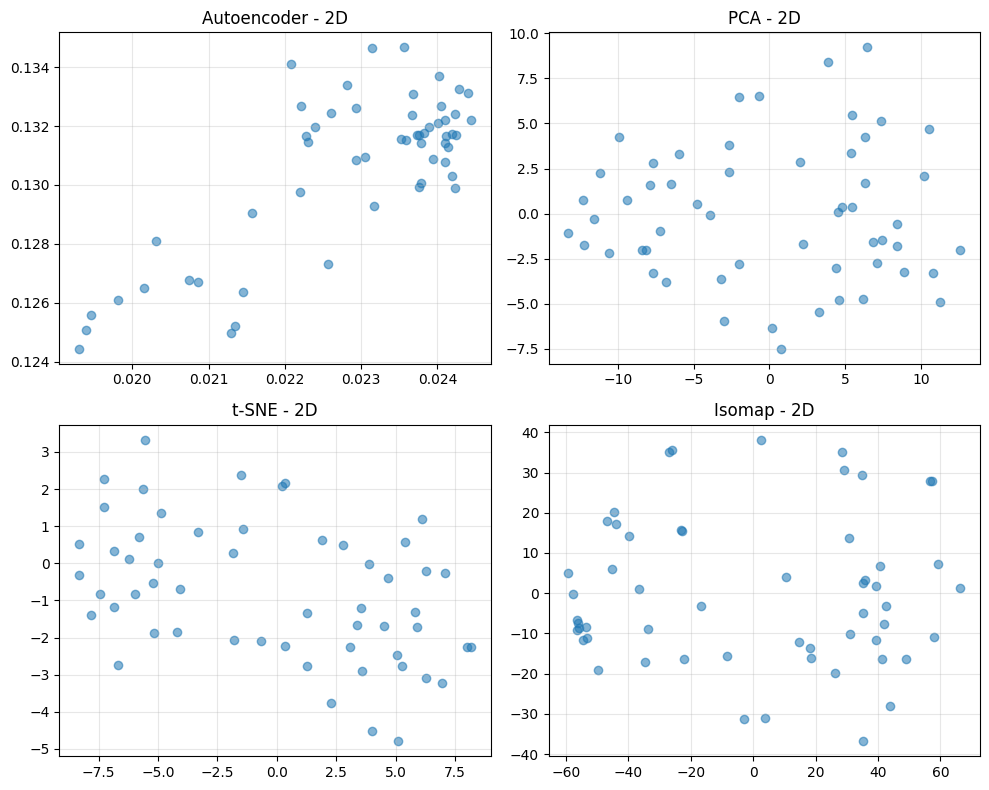

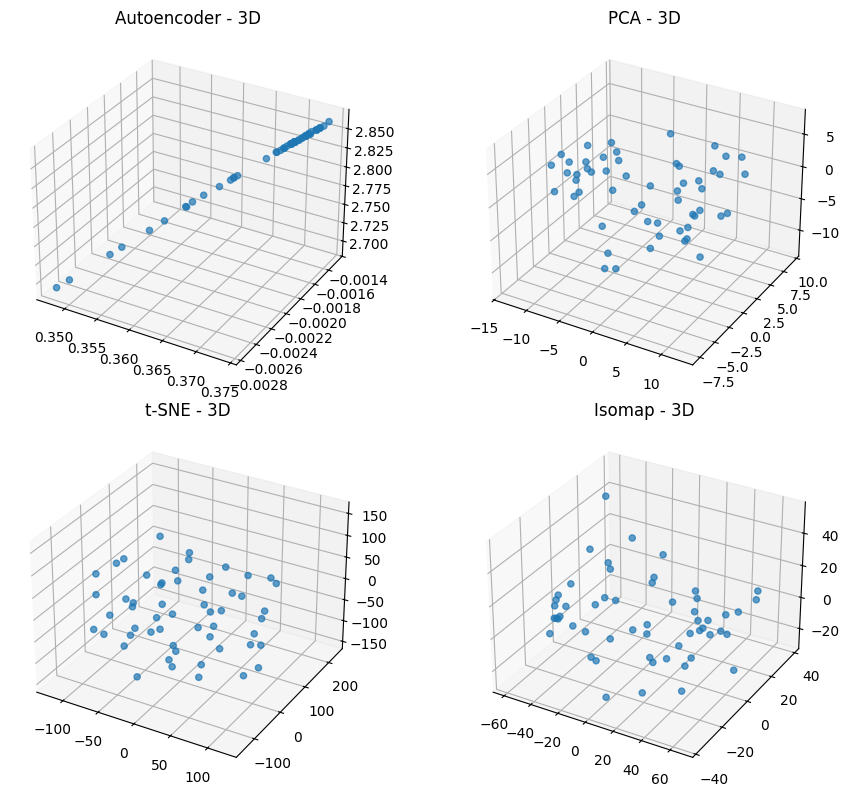

In [ ]:
# Normalizar datos para métodos tradicionales
scaler = StandardScaler()
Xp_scaled = scaler.fit_transform(X_datap)

## AutoEncoder
p_encoded_2d = encoder_2d.predict(X_datap)
p_encoded_3d = encoder_3d.predict(X_datap)

# PCA
p_pca_2d = PCA(n_components=2)
p_pca_3d = PCA(n_components=3)
p_pca_result_2d = p_pca_2d.fit_transform(Xp_scaled)
p_pca_result_3d = p_pca_3d.fit_transform(Xp_scaled)

# t-SNE
p_tsne_2d = TSNE(n_components=2, random_state=42, perplexity=min(15, len(X_data)-1))
p_tsne_3d = TSNE(n_components=3, random_state=42, perplexity=min(15, len(X_data)-1))
p_tsne_result_2d = p_tsne_2d.fit_transform(Xp_scaled)
p_tsne_result_3d = p_tsne_3d.fit_transform(Xp_scaled)

# Isomap
p_isomap_2d = Isomap(n_components=2, n_neighbors=min(5, len(X_datap)-1))
p_isomap_3d = Isomap(n_components=3, n_neighbors=min(5, len(X_datap)-1))
p_isomap_result_2d = p_isomap_2d.fit_transform(Xp_scaled)
p_isomap_result_3d = p_isomap_3d.fit_transform(Xp_scaled)

# Comparar todos los métodos
p_methods_2d = {
    'Autoencoder': p_encoded_2d,
    'PCA': p_pca_result_2d,
    't-SNE': p_tsne_result_2d,
    'Isomap': p_isomap_result_2d
}

p_methods_3d = {
    'Autoencoder': p_encoded_3d,
    'PCA': p_pca_result_3d,
    't-SNE': p_tsne_result_3d,
    'Isomap': p_isomap_result_3d
}

# Visualizar comparaciones
compare_methods(p_methods_2d, p_methods_3d)

Posteriormente podemos identificar cada clase, aplicando un método de clustering como k-means; ya que sabemos que solo existen dos categorias.